supply and demand analysis
calculate changes in oil reserves, including the SPR, weekly and compared to last year
determine if changes are in line with expectations
if not in line with expectations determine if it is do to higher demand, lower production, more exports or a combination

In [80]:
import pandas as pd
import USA_oil_data as oil
import prices
from FRED_oil_data import get_fred_data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [81]:
weekly_stocks = oil.weekly_stocks()
spr = oil.spr_reserves()

In [82]:
merged = pd.merge(weekly_stocks, spr, on='period')
merged.sort_index(inplace=True)

In [83]:
ticks = [x for x in range(0, 1400000, 200000)]

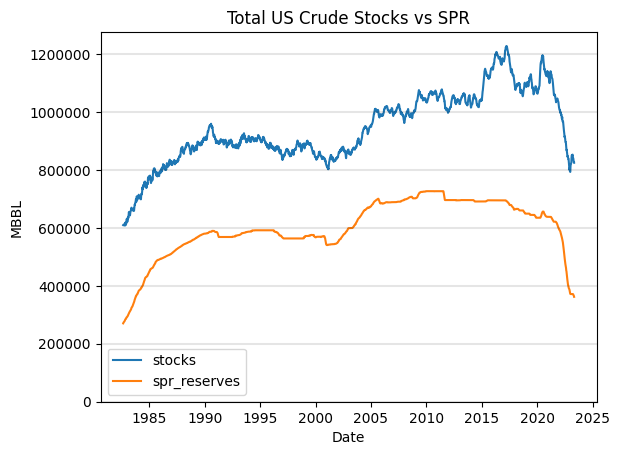

In [86]:
plt.plot(merged)

plt.yticks(ticks)
plt.ticklabel_format(axis='y', style='plain')
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.legend(merged.columns)
plt.title("Total US Crude Stocks vs SPR")
plt.xlabel('Date')
plt.ylabel('MBBL')
plt.show()

In [6]:
weekly_stocks = weekly_stocks.to_frame()

In [7]:
weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month
weekly_stocks = weekly_stocks[weekly_stocks['year'] > 2015]
monthly_average = weekly_stocks.groupby('month').mean()

In [8]:
grouped = weekly_stocks.groupby('year')

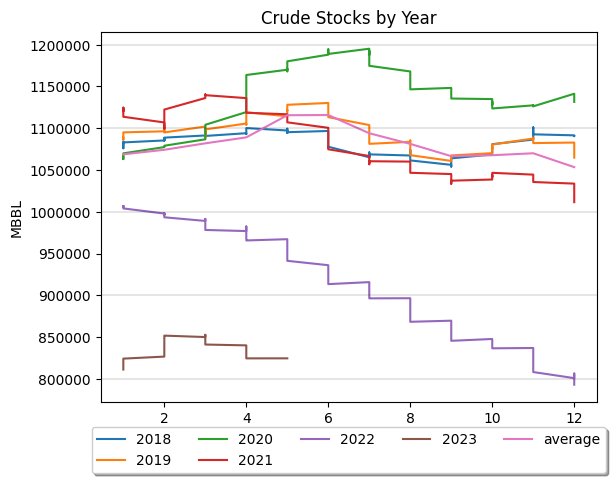

In [77]:
fig, ax = plt.subplots()

for name, group in grouped:
    ax.plot(group['month'], group['stocks'], label=name)
ax.plot(monthly_average.index, monthly_average['stocks'], label='average' )
plt.ticklabel_format(axis='y', style='plain')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
#add horizontal lines
ticks = [x for x in range(800000, 1300000, 100000)]
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.title('Crude Stocks by Year')
plt.xlabel('Month')
plt.ylabel('MBBL')
plt.show()

In [10]:
weekly_stocks = oil.weekly_stocks()
weekly_stocks = weekly_stocks.to_frame()

weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month

weekly_stocks['diff'] = weekly_stocks['stocks'].diff(-1)
weekly_stocks = weekly_stocks[weekly_stocks['year'] >= 2018]

week_info = weekly_stocks.index.isocalendar()
week_number = week_info['week']

merged_df = pd.merge(week_number, weekly_stocks, left_index=True, right_index=True)

In [11]:
grouped = merged_df.groupby('year')

In [12]:
weeks = grouped['week'].unique()
years = len(grouped['year'].unique())
width = 0.8/years

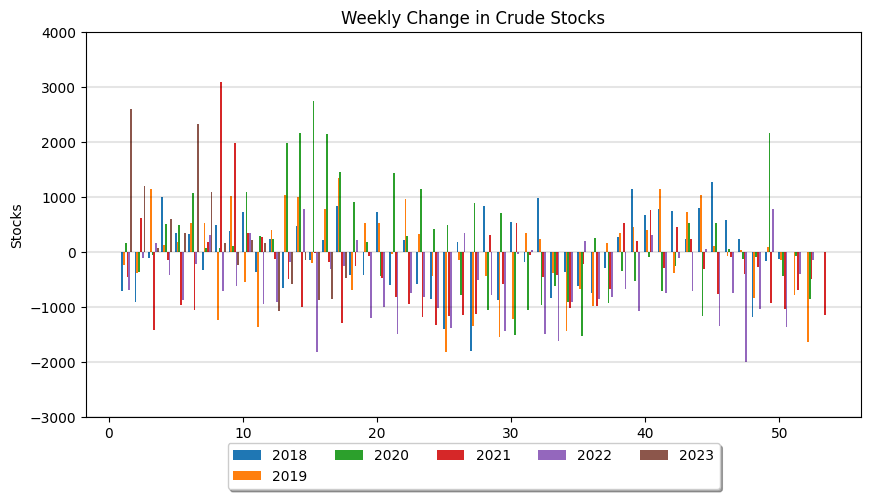

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
i = 0
for name, group in grouped:
    data = group[group['week'] < 53]
    data = group['diff']/7
    positions = group['week']


    ax.bar(positions + i * width, data, width=width, label=name)
    i += 1

ticks = [x for x in range(-3000, 4000, 1000)]
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.ylim(-3000,4000)

ax.set_ylabel('Stocks')
ax.set_xlabel('Week')
#move legend to bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Weekly Change in Crude Stocks')

plt.show()

In [14]:
imports, exports = oil.imports_exports(only_crude=False)

In [15]:
imports_exports = pd.merge(imports, exports, on='period')

imports_exports['year'] = imports_exports.index.year
imports_exports = imports_exports[imports_exports['year'] > 2005]

In [16]:
imports_exports['net'] = imports_exports['imports'] - imports_exports['exports']

Text(0.5, 1.0, 'Imports, Exports and Net Imports')

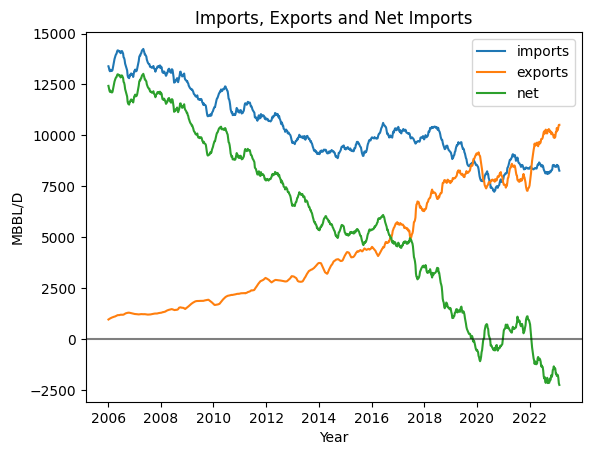

In [72]:
plt.plot(imports_exports[['imports', 'exports', 'net']].rolling(12).mean())
plt.legend(imports_exports[['imports', 'exports', 'net']])
plt.axhline(0, color='black', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('MBBL/D')
plt.title('Imports, Exports and Net Imports')

In [17]:
def convert_to_monthly(data, name='value'):
    data['days_in_month'] = data.index.days_in_month
    data['imports'] = data['imports'] * data['days_in_month']
    data['exports'] = data['exports'] * data['days_in_month']
    data = data[['imports', 'exports']]
    data['net_imports'] = data['imports'] - data['exports']
    data['net'] = data['imports'] - data['exports']
    data = data['net']
    data = data.rename(name)
    return data

In [57]:
#supply data:

#production
production = oil.mbbl_production()

#reserves
reserves = oil.crude_oil_stocks()



#demand data:
#product supplied
product_supplied = oil.weekly_product_supplied()
monthly_product_supplied = product_supplied.resample('M').sum()
monthly_product_supplied.index = monthly_product_supplied.index - pd.offsets.MonthBegin(1)
monthly_product_supplied.rename("monthly_product_supplied", inplace=True)

#net exports (converted from MBBL/D to MBBL)
imp, exp = oil.imports_exports(only_crude=False)
imp_exp = pd.merge(imp, exp, on='period')
monthly_imp_exp = imp_exp.resample('M').sum()
monthly_imp_exp.index = monthly_imp_exp.index - pd.offsets.MonthBegin(1)
monthly_imp_exp['net_imports'] = monthly_imp_exp['imports'] - monthly_imp_exp['exports']

consumption = oil.weekly_product_supplied()
#sales (not updated since March 2022)
#gas_end_users = oil.gasoline_sales_end_user()
#gas_resale = oil.gasoline_sales_resale()


In [58]:
#merge all data into one dataframe
supply_demand = pd.merge(production, reserves, on='period')
supply_demand = pd.merge(supply_demand, monthly_product_supplied, on='period')
#supply_demand = pd.merge(supply_demand, monthly_imp_exp['net_imports'], on='period')


In [59]:
changes = supply_demand.diff(12)
#changes = supply_demand.pct_change(12)

In [63]:
changes = changes[changes.index > '2018-12-01']
changes.index = changes.index.strftime('%Y-%m')

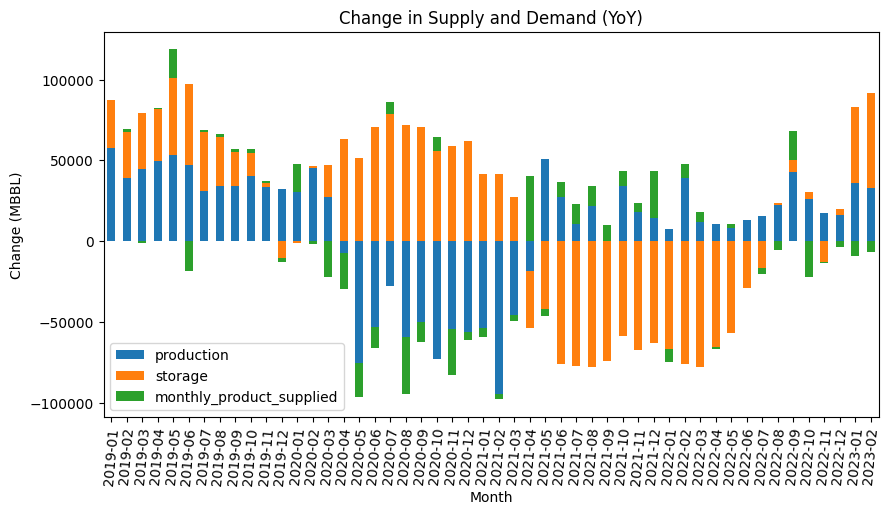

In [75]:
fig, ax = plt.subplots(figsize=(10,5))
changes.plot(kind='bar', stacked=True, ax=ax)
plt.title('Change in Supply and Demand (YoY)')
ax.set_xlabel('Month')
ax.set_ylabel('Change (MBBL)')
plt.xticks(rotation=85)
plt.show()

In [52]:
monthly_net_exports = monthly_imp_exp['net_imports']
monthly_net_exports = monthly_net_exports[monthly_net_exports.index > '2018-12-01']
monthly_net_exports.index = monthly_net_exports.index.strftime('%Y-%m')

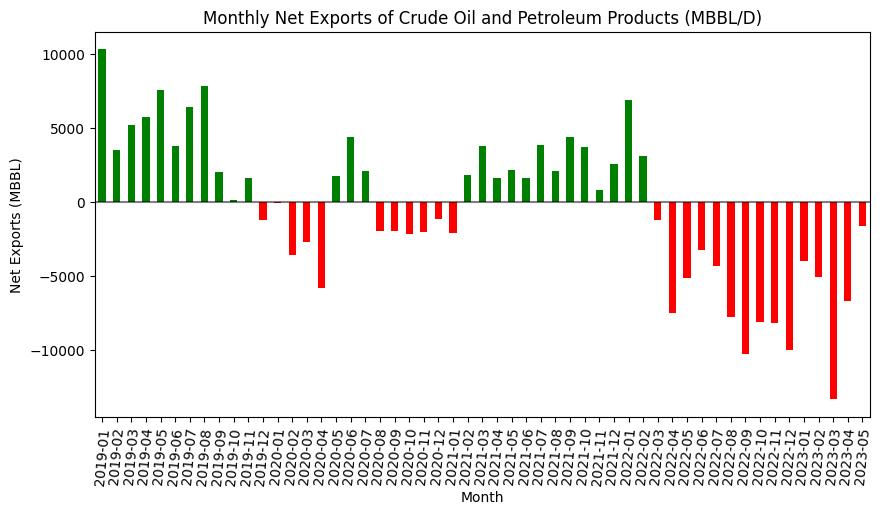

In [66]:
fig, ax = plt.subplots(figsize=(10,5))

monthly_net_exports.plot(kind='bar', ax=ax)
for i, val in enumerate(monthly_net_exports):
    if val > 0:
        ax.patches[i].set_facecolor('green')
    else:
        ax.patches[i].set_facecolor('red')

plt.axhline(0, color='black', alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('Net Exports (MBBL/D)')

plt.xticks(rotation=85)  # Optional: Rotate the x-axis tick labels for better visibility
plt.title('Monthly Net Exports of Crude Oil and Petroleum Products (MBBL/D)')
plt.show()

In [120]:
changes = spr.diff(52)

In [121]:
changes = changes[changes.index > "2018-12-01"]

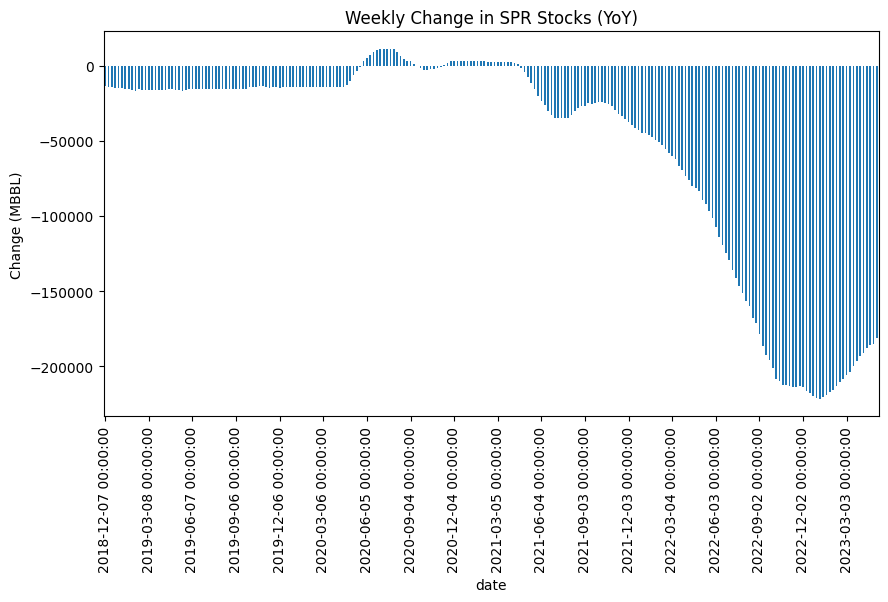

In [125]:
fig, ax = plt.subplots(figsize=(10,5))
changes.plot(kind='bar', ax=ax)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=13))
ax.set_xlabel('date')
ax.set_ylabel('Change (MBBL)')
plt.title('Weekly Change in SPR Stocks (YoY)')
plt.show()